In [4]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# Specify each path

In [5]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.keras'
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

# Set number of classes

In [6]:
NUM_CLASSES = 60

# Dataset reading

In [7]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [8]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Model building

In [10]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(30, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [11]:
model.summary()  

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout (Dropout)               │ (None, 42)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 50)             │         2,150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 30)             │         1,530 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 60)             │         1,860 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,540 (21.64 KB)

 Trainable params: 5,540 (21.64 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False
)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)
# Define the ReduceLROnPlateau callback
reducelr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.2, patience=5, min_lr=0.0001
)

In [13]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [14]:
history = model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback,reducelr_callback]
)

Epoch 1/1000
534/545 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1421 - loss: 3.2585
Epoch 1: saving model to model/keypoint_classifier/keypoint_classifier.keras
545/545 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.1444 - loss: 3.2432 - val_accuracy: 0.7051 - val_loss: 1.3147 - learning_rate: 0.0010
Epoch 2/1000
540/545 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4507 - loss: 1.6193
Epoch 2: saving model to model/keypoint_classifier/keypoint_classifier.keras
545/545 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4510 - loss: 1.6182 - val_accuracy: 0.8478 - val_loss: 0.7865 - learning_rate: 0.0010
Epoch 3/1000
537/545 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5467 - loss: 1.3051
Epoch 3: saving model to model/keypoint_classifier/keypoint_classifier.keras
545/545 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5470 - loss: 1.3044 - val_accuracy: 0.9090 - val_loss: 0.5855 - learning_rate: 0.0010
Epoch 4/1000
532/545 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5987 - loss: 1

In [15]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9783 - loss: 0.1670


In [16]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

# Inference Test

In [17]:
print(y_test[0])

53


In [18]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
[1.72629691e-31 0.00000000e+00 9.24441503e-36 0.00000000e+00
 4.12046964e-29 3.01412775e-37 2.46260871e-18 4.79090500e-23
 1.59054680e-22 4.93955069e-32 5.37687279e-37 9.67775283e-37
 2.74607473e-26 5.06594995e-27 1.90446094e-17 1.27129573e-30
 0.00000000e+00 1.64975404e-30 3.69202887e-37 7.10928535e-26
 2.61474575e-30 2.08357634e-30 4.88404398e-20 1.29949118e-19
 4.61755511e-16 4.13964226e-05 3.46675763e-19 0.00000000e+00
 4.42762795e-19 7.16220752e-17 0.00000000e+00 8.70402674e-20
 1.40184472e-36 1.04861274e-20 0.00000000e+00 2.90181617e-34
 5.08503886e-20 3.89374970e-36 3.75382924e-32 1.21773295e-16
 1.93204261e-37 4.26301659e-33 4.42094719e-33 6.19651210e-38
 0.00000000e+00 1.52594370e-20 3.23526796e-21 1.98147099e-09
 3.83139558e-20 1.12784363e-32 6.13487802e-11 2.50086795e-15
 5.02573981e-12 9.99184430e-01 2.47895042e-12 8.96492409e-08
 6.49088747e-07 7.73180800e-04 1.73808488e-07 3.76359450e-16]
53


# Classification Report

In [19]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)

    # fig, ax = plt.subplots(figsize=(7, 6))
    # sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    # ax.set_ylim(len(set(y_true)), 0)
    # plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

727/727 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Classification Report
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       396
           1       0.71      1.00      0.83       347
           2       0.80      0.84      0.82       425
           3       1.00      1.00      1.00       354
           4       0.99      1.00      0.99       251
           5       1.00      1.00      1.00       245
           6       1.00      1.00      1.00       258
           7       1.00      0.97      0.98       316
           8       1.00      1.00      1.00       411
           9       1.00      0.80      0.89       425
          10       1.00      0.34      0.51       331
          11       0.55      1.00      0.71       264
          12       0.98      1.00      0.99       493
          13       1.00      0.98      0.99       258
          14       1.00      1.00      1.00       212
          15       1.00      1.00      1.00       248
          16      

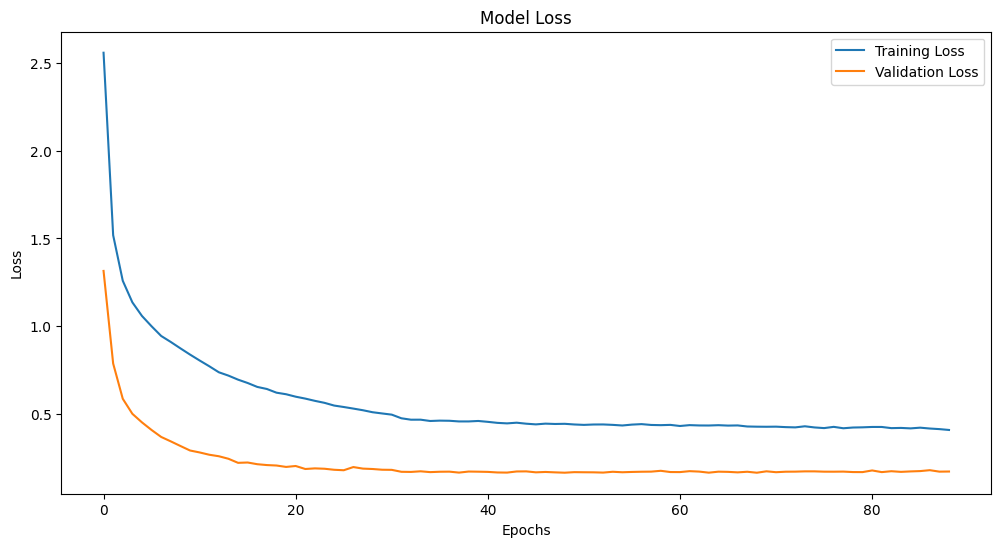

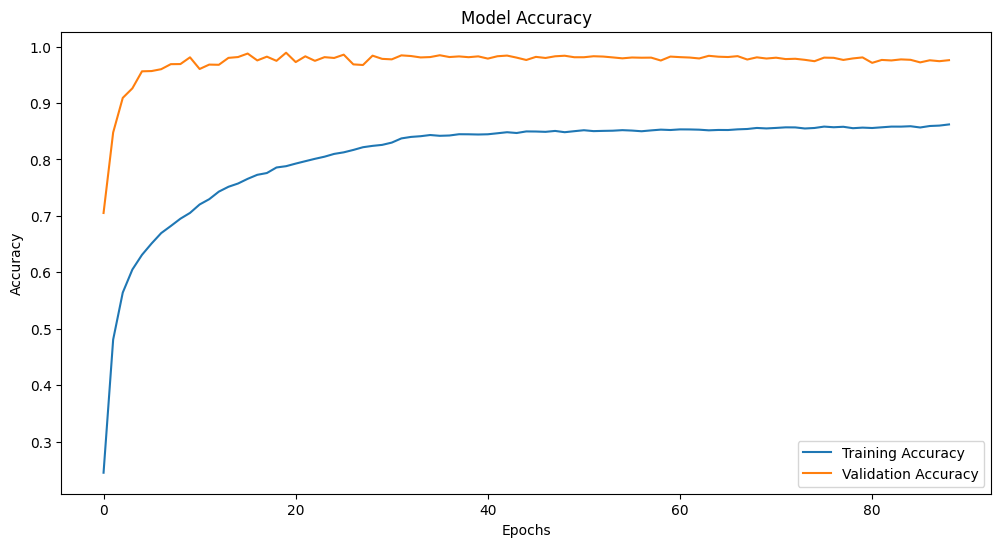

In [20]:
# Plotting the learning curve
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

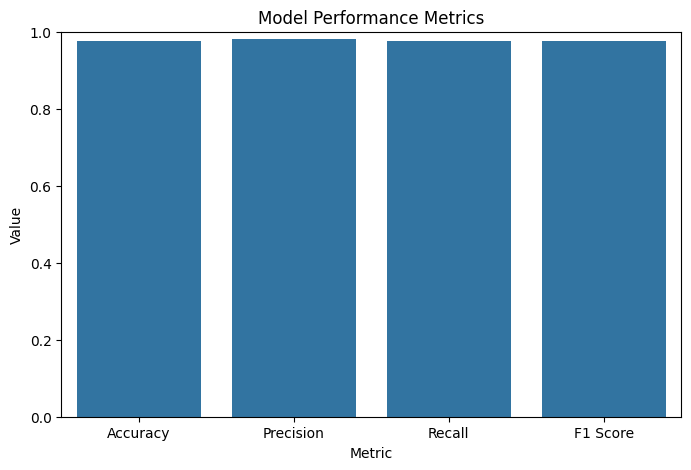

      Metric     Value
0   Accuracy  0.975864
1  Precision  0.982334
2     Recall  0.975864
3   F1 Score  0.975155


In [21]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Create a DataFrame for comparison
metrics_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
    'Value': [accuracy, precision, recall, f1]
})

# Plot the comparison
plt.figure(figsize=(8, 5))
sns.barplot(x='Metric', y='Value', data=metrics_df)
plt.title('Model Performance Metrics')
plt.ylim(0, 1)
plt.show()

# Display the DataFrame
print(metrics_df)

# Convert to model for Tensorflow-Lite

In [22]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

In [23]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\anish\AppData\Local\Temp\tmpel1ih2_h\assets


INFO:tensorflow:Assets written to: C:\Users\anish\AppData\Local\Temp\tmpel1ih2_h\assets


Saved artifact at 'C:\Users\anish\AppData\Local\Temp\tmpel1ih2_h'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 42), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 60), dtype=tf.float32, name=None)
Captures:
  1888720813520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1888720813136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1888772769936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1888772782992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1888772768592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1888772781648: TensorSpec(shape=(), dtype=tf.resource, name=None)


9824

# Inference test

In [24]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [25]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [26]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [27]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 0 ns
